In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pandas as pd
from PIL import Image
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dropout, Input,Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.models import model_from_json
from sklearn.metrics import confusion_matrix
from keras.models import load_model

In [ ]:
def getZipFromDrive(fileId):
    # Install the PyDrive wrapper & import libraries.
    # This only needs to be done once per notebook.
    !pip install -U -q PyDrive
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from io import BytesIO
    import zipfile
    from google.colab import auth
    from oauth2client.client import GoogleCredentials

    # Authenticate and create the PyDrive client.
    # This only needs to be done once per notebook.
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)

    # Download a file based on its file ID.
    #
    # A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
    # Music " 1p90klezsnQnleQdAZMgkGAf0ZHWepE3s "
    #https://drive.google.com/open?id=1frfTp6gQ10OWnLDvjT6pN-YTH56yelZy
    print("Downloading...")
    downloaded = drive.CreateFile({'id': fileId})
    
    toUnzipStringContent = downloaded.GetContentString(encoding='cp862')
    toUnzipBytesContent = BytesIO(toUnzipStringContent.encode('cp862'))
    readZipfile = zipfile.ZipFile(toUnzipBytesContent, "r")
    readZipfile.extractall()
  
getZipFromDrive("1frfTp6gQ10OWnLDvjT6pN-YTH56yelZy")

Downloading...


In [ ]:
source="/content/train/"

In [ ]:
def getTrainFiles(classIndex):
    trainDir=source+"c"+str(classIndex)
    files=[os.path.join(trainDir, f) for f in os.listdir(trainDir)]
    return files

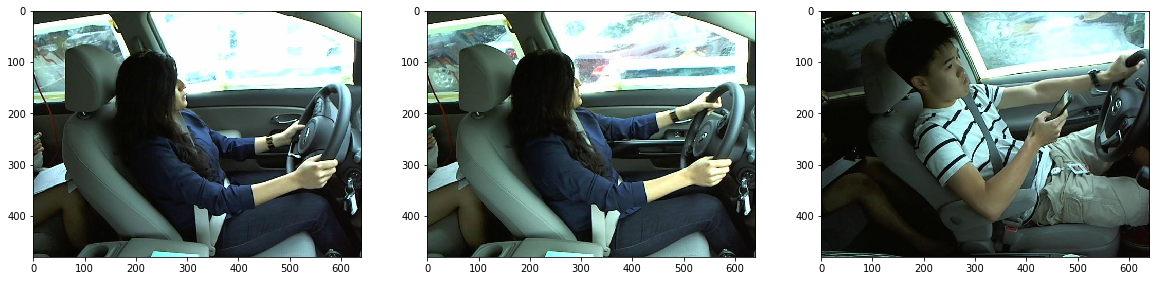

/content/train/c0/img_60651.jpg
/content/train/c0/img_29868.jpg
/content/train/c1/img_35243.jpg


In [ ]:
c0Files= getTrainFiles(0)
c1Files=getTrainFiles(1)

# img=mpimg.imread(c0Files[0])
# imgplot = plt.imshow(img)
# img.shape
# plt.show()
c01=mpimg.imread(c0Files[0])
c02=mpimg.imread(c0Files[1])
c11=mpimg.imread(c1Files[0])
fig,axes=plt.subplots(1,3,figsize=(20, 20))
axes[0].imshow(c01)
axes[1].imshow(c02)
axes[2].imshow(c11)
plt.show()
print(c0Files[0])
print(c0Files[1])
print(c1Files[0])

In [ ]:
# Create a class to store global variables. Easier for adjustments.
class Configuration:
    def __init__(self):
        self.epochs = 25
        self.batch_size = 50
        self.maxwidth =0
        self.maxheight=0
        self.minwidth = 35000
        self.minheight = 35000
        self.imgcount=0
        self.img_width_adjust = 480
        self.img_height_adjust= 360
        self.data_dir = source
config = Configuration()

In [ ]:
#Count the number of files in each subdirectory
def listDirectoryCounts(path):
    d = []
    for subdir, dirs_in_subdir, files in os.walk(path,topdown=False):
        filecount = len(files)
        dirname = subdir
        d.append((dirname,filecount))
    return d 

def SplitCat(df):
    for index, row in df.iterrows():
        directory=row['Category'].split('\\')
        if directory[-1]!='':
            directory=directory[-1]
            df.at[index,'Category']=directory
        else:
            df.drop(index, inplace=True)
    return
#Get image count per category
dirCount=listDirectoryCounts(config.data_dir)
categoryInfo = pd.DataFrame(dirCount, columns=['Category','Count'])
SplitCat(categoryInfo)
categoryInfo=categoryInfo.sort_values(by=['Category'])
print(categoryInfo.to_string(index=False))

          Category  Count
   /content/train/      0
 /content/train/c0   2489
 /content/train/c1   2267
 /content/train/c2   2317
 /content/train/c3   2346
 /content/train/c4   2326
 /content/train/c5   2312
 /content/train/c6   2325
 /content/train/c7   2002
 /content/train/c8   1911
 /content/train/c9   2129


In [ ]:
#Find the largest and smallest dimensions of all the pictures
def findPictureDims(path):
    for subdir, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".jpg"):
                config.imgcount+=1
                filename = os.path.join(subdir, file)
                image = Image.open(filename)
                width, height = image.size
                if width < config.minwidth:
                    config.minwidth = width
                if height < config.minheight:
                    config.minheight = height
                if width > config.maxwidth:
                    config.maxwidth = width
                if height > config.maxheight:
                    config.maxheight = height
    return
findPictureDims(config.data_dir)
print("Minimum Width:\t",config.minwidth, "\tMinimum Height:",config.minheight)
print("Maximum Width:\t",config.maxwidth, "\tMaximum Height:",config.maxheight, "\tImage Count:\t",config.imgcount)

Minimum Width:	 640 	Minimum Height: 480
Maximum Width:	 640 	Maximum Height: 480 	Image Count:	 22424


In [ ]:
#Alexnet Model Definition
def build_model():
  #  x = x = MaxPooling2D((2,2), padding='same')(x)(x)
    #Instantiate an empty model
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224,3)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), padding='same'))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add( MaxPooling2D((2,2), padding='same'))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add( MaxPooling2D((2,2), padding='same'))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add( MaxPooling2D((2,2), padding='same'))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add( MaxPooling2D((2,2), padding='same'))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(output_dim = 10, activation='softmax'))


    # model.add(Dense(10))
    # model.add(Activation('softmax'))

    # Compile the model
    sgd = SGD(lr=0.0009, decay=0.00001, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=["accuracy"])
    return model

In [ ]:
#Setup data, and create split for training, testing 80/20
def setup_data(train_data_dir, val_data_dir, img_width=config.img_width_adjust, img_height=config.img_height_adjust, batch_size=config.batch_size):
    
    train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,                           
    horizontal_flip=True,
    validation_split=0.2) # set validation split
    

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        shuffle=True,  
        batch_size=batch_size,
        class_mode='categorical',
        subset='training')
    
    validation_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        shuffle=True,  
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation')
        #Note uses training dataflow generator
    return train_generator, validation_generator

In [ ]:
def fit_model(model, train_generator, val_generator, batch_size, epochs):
    model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=val_generator.samples // batch_size,
        verbose=1)
    return model



In [ ]:
def eval_model(model, val_generator, batch_size):
    scores = model.evaluate_generator(val_generator, steps=val_generator.samples // batch_size)
    print("Loss: " + str(scores[0]) + " Accuracy: " + str(scores[1]))


In [ ]:
# Create Data 80/20
train_generator, val_generator = setup_data(config.data_dir, config.data_dir, batch_size=config.batch_size,img_width=224, img_height=224)


Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


In [ ]:
train_generator.class_indices

{'c0': 0,
 'c1': 1,
 'c2': 2,
 'c3': 3,
 'c4': 4,
 'c5': 5,
 'c6': 6,
 'c7': 7,
 'c8': 8,
 'c9': 9}

In [ ]:
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D

In [ ]:
# Build the model and show the summary data (note trainable parameters)
model = build_model()
print (model.summary())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), a


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 114, 114, 64)      0         
__

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), activation="relu")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), activation="relu")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), activation="relu")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=10)`


In [ ]:
# Fit the model (If not already present)
# exists = os.path.isfile('dd_model.h5')
# if exists:
#     model = load_model('dd_model.h5')
# else:
model = fit_model(model, train_generator, val_generator,
                  batch_size=config.batch_size,
                  epochs=config.epochs)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/25





358/358 [==============================] - 343s 959ms/step - loss: 2.3014 - acc: 0.1087 - val_loss: 2.3002 - val_acc: 0.1112
Epoch 2/25
358/358 [==============================] - 335s 936ms/step - loss: 2.3002 - acc: 0.1109 - val_loss: 2.2998 - val_acc: 0.1097
Epoch 3/25
358/358 [==============================] - 331s 925ms/step - loss: 2.2998 - acc: 0.1114 - val_loss: 2.2992 - val_acc: 0.1124
Epoch 4/25
358/358 [==============================] - 332s 927ms/step - loss: 2.2995 - acc: 0.1112 - val_loss: 2.2993 - val_acc: 0.1095
Epoch 5/25
358/358 [==============================] - 332s 927ms/step - loss: 2.2991 - acc: 0.1104 - val_loss: 2.2985 - val_acc: 0.1135
Epoch 6/25
358/358 [==============================] - 331s 926ms/step - loss: 2.2987 - acc: 0.1109 - val_loss: 2.2970 - val_acc: 0.1104
Epoch 7/25
358/358 [==============================] - 322s 899ms/step - loss: 2.29

In [ ]:
# Evaluate your model.
eval_model(model, val_generator, batch_size=config.batch_size)

Loss: 0.09697840542773183 Accuracy: 0.9728089879068096


In [ ]:
def plot_confusion_matrix(prediction,actual, classes,
                          normalize=False,
                          title='Confusion matrix',https://drive.google.com/drive/u/0/my-drive
                          cmap=plt.cm.Blues,confText=True,
                          colorBar=True ):
    """
    This function prints and plots the confusion matrix.
    """
    cm = confusion_matrix(actual, prediction)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, cmap=cmap)
    plt.title(title)
    if(colorBar):
        plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    if confText:
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:

print("length: ",len(val_generator))
# predict = model.predict_generator(val_generator,steps=len(val_generator))
index=0
# for val in predict:
#     print(val)
#     print(val.argmax(axis=-1))
#     print("index ",index)
#     index +=1
preds=[]
actual=[]
for var in range(len(val_generator)):
    x,y=val_generator[var]
    predict = model.predict(x)
    c_preds=[val.argmax(axis=-1) for val in predict]
    c_actual=[val.argmax(axis=-1) for val in y]
    if(index%10==0) :
        print(index)
    index+=1
    preds.extend(c_preds)
    actual.extend(c_actual)



length:  90
0
10
20
30
40
50
60
70
80


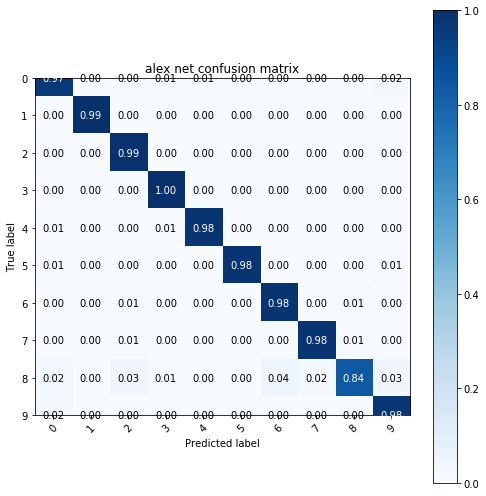

In [ ]:
plt.figure(figsize=(5,7))
plot_confusion_matrix(preds,actual,range(10),normalize=True,title="alex net confusion matrix",confText=True)

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("dd_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("dd_model_weights.h5")
model.save('dd_model.h5')
print("Saved model to disk")

Saved model to disk


In [ ]:
#view results on test set
sample_data_dir="/content/test"
test_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split
    
test_generator = test_datagen.flow_from_directory(
        sample_data_dir,
        target_size=(224, 224),
        color_mode="rgb",
        shuffle = False,
        class_mode=None,
        batch_size=1)
filenames = test_generator.filenames
nb_samples = len(filenames)
print(nb_samples)
print(filenames)



Found 0 images belonging to 0 classes.
0
[]


In [ ]:
class_desc=['c0: normal driving','c1: texting - right','c2: talking on the phone - right','c3: texting - left',
    'c4: talking on the phone - left','c5: operating the radio','c6: drinking','c7: reaching behind','c8: hair and makeup',
    'c9: talking to passenger']
predict = model.predict_generator(test_generator,steps = nb_samples)
filelist=[os.path.join(sample_data_dir+"New Folder", f) for f in os.listdir(sample_data_dir+"New Folder")]
fig,axes=plt.subplots(len(filelist),1,figsize=(20, 70))
for i in range(0,len(filelist)):
    img=mpimg.imread(filelist[i])
    axes[i].set_xlabel(class_desc[predict[i].argmax(axis=-1)])
    axes[i].imshow(img)
plt.show()